In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import tensorflow as tf
from sklearn.metrics import confusion_matrix

import itertools

In [44]:
DATA_PATH = "../data/final_tweets/"

train_df = pd.read_csv(DATA_PATH +'train_df.csv')
valid_df = pd.read_csv(DATA_PATH +'validate_df.csv')
test_df = pd.read_csv(DATA_PATH + 'test_df.csv')

full_dataset_df =  pd.read_csv(DATA_PATH + 'full_tweets_df.csv')

X_train = train_df['tweet_text']
Y_train = train_df['text_info']

X_valid = valid_df['tweet_text']
Y_valid = valid_df['text_info']

X_test = test_df['tweet_text']
Y_test = test_df['text_info']

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)

# train data
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len)

# validate data
valid_sequences = tok.texts_to_sequences(X_valid)
valid_sequences_matrix = sequence.pad_sequences(valid_sequences,maxlen=max_len)

# test_data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

## Functions

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
def plot_summaries(data1, data2, title, ylabel,fname):
    plt.plot(data1)
    plt.plot(data2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(fname+".png")

In [102]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(2*layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

## Unbalanced Dataset

In [103]:
neg, pos = np.bincount(train_df["text_info"])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 8933
    Positive: 5922 (66.29% of total)

Weight for class 0: 1.48
Weight for class 1: 0.75


## With Early Stopping -> Only 2 Epochs (TRAIN ON ONLY TRAINING DATA)

In [57]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [118]:
model_ES = RNN()
model_ES.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=METRICS)
training_history_ES = model_ES.fit(train_sequences_matrix,Y_train,batch_size=64,epochs=10,\
          validation_data = (valid_sequences_matrix, Y_valid),class_weight=class_weight, \
                                   callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])
accr = model_ES.evaluate(test_sequences_matrix,Y_test)

Epoch 1/10
140/140 [==============================] - 11s 76ms/step - loss: 0.5197 - tp: 5688.0000 - fp: 1006.0000 - tn: 2651.0000 - fn: 1503.0000 - accuracy: 0.7687 - precision: 0.8497 - recall: 0.7910 - auc: 0.8358 - val_loss: 0.4187 - val_tp: 1090.0000 - val_fp: 164.0000 - val_tn: 478.0000 - val_fn: 182.0000 - val_accuracy: 0.8192 - val_precision: 0.8692 - val_recall: 0.8569 - val_auc: 0.8803
Epoch 2/10
140/140 [==============================] - 10s 71ms/step - loss: 0.4084 - tp: 4997.0000 - fp: 644.0000 - tn: 2367.0000 - fn: 925.0000 - accuracy: 0.8244 - precision: 0.8858 - recall: 0.8438 - auc: 0.8956 - val_loss: 0.4102 - val_tp: 1070.0000 - val_fp: 139.0000 - val_tn: 503.0000 - val_fn: 202.0000 - val_accuracy: 0.8218 - val_precision: 0.8850 - val_recall: 0.8412 - val_auc: 0.8871
Epoch 3/10
60/60 [==============================] - 1s 14ms/step - loss: 0.3951 - tp: 1015.0000 - fp: 120.0000 - tn: 526.0000 - fn: 254.0000 - accuracy: 0.8047 - precision: 0.8943 - recall: 0.7998 - auc: 

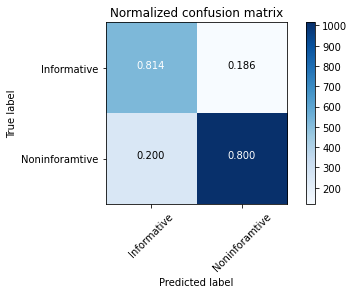

In [122]:
predictions = model_ES.predict(test_sequences_matrix)
p = 0.5
cm =  confusion_matrix(Y_test, predictions > p)
plot_confusion_matrix(cm, classes=["Informative","Noninforamtive"], normalize=True,
                      title='Normalized confusion matrix')

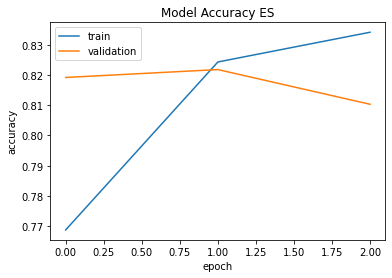

In [119]:
plot_summaries(training_history_ES.history['accuracy'],training_history_ES.history['val_accuracy'],\
              "Model Accuracy ES", "accuracy", "imgs/acc_ES")

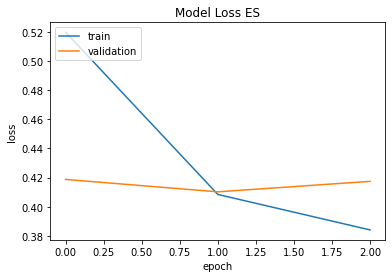

In [120]:
plot_summaries(training_history_ES.history['loss'],training_history_ES.history['val_loss'],\
              "Model Loss ES", "loss","imgs/loss_ES")

## With Early Stopping -> Only 2 Epochs (TRAIN ON ONLY TRAINING AND VAL DATA DATA)

In [124]:
# validate data
train_val_df = pd.concat([X_train, X_valid])
Y_train_val  = pd.concat([Y_train, Y_valid])
train_valid_sequences = tok.texts_to_sequences(train_val_df)
train_valid_sequences_matrix = sequence.pad_sequences(train_valid_sequences,maxlen=max_len)

In [136]:
neg, pos = np.bincount(Y_train_val)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 10847
    Positive: 7194 (66.32% of total)

Weight for class 0: 1.48
Weight for class 1: 0.75


In [139]:
model_ES = RNN()
model_ES.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=METRICS)
training_history_ES = model_ES.fit(train_valid_sequences_matrix,Y_train_val,batch_size=64,epochs=6,\
                                   class_weight=class_weight)
accr = model_ES.evaluate(test_sequences_matrix,Y_test)

Epoch 1/6
170/170 [==============================] - 11s 67ms/step - loss: 0.5012 - tp: 6491.0000 - fp: 1041.0000 - tn: 3258.0000 - fn: 1972.0000 - accuracy: 0.7639 - precision: 0.8618 - recall: 0.7670 - auc: 0.8455
Epoch 2/6
170/170 [==============================] - 11s 67ms/step - loss: 0.4051 - tp: 6098.0000 - fp: 777.0000 - tn: 2876.0000 - fn: 1096.0000 - accuracy: 0.8273 - precision: 0.8870 - recall: 0.8477 - auc: 0.8970
Epoch 3/6
170/170 [==============================] - 11s 67ms/step - loss: 0.3856 - tp: 6084.0000 - fp: 709.0000 - tn: 2944.0000 - fn: 1110.0000 - accuracy: 0.8323 - precision: 0.8956 - recall: 0.8457 - auc: 0.9074
Epoch 4/6
170/170 [==============================] - 11s 67ms/step - loss: 0.3699 - tp: 6069.0000 - fp: 675.0000 - tn: 2978.0000 - fn: 1125.0000 - accuracy: 0.8341 - precision: 0.8999 - recall: 0.8436 - auc: 0.9147
Epoch 5/6
170/170 [==============================] - 11s 67ms/step - loss: 0.3688 - tp: 6035.0000 - fp: 623.0000 - tn: 3030.0000 - fn: 1159

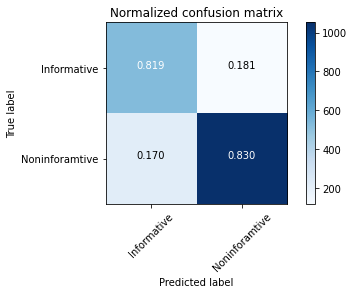

In [140]:
predictions = model_ES.predict(test_sequences_matrix)
p = 0.5
cm =  confusion_matrix(Y_test, predictions > p)
plot_confusion_matrix(cm, classes=["Informative","Noninforamtive"], normalize=True,
                      title='Normalized confusion matrix')

In [143]:
from sklearn.metrics import classification_report
target_names = ["Informative","Noninforamtive"]
predictions[predictions >0.5] = 1
predictions[predictions <=0.5] = 0
print(classification_report(Y_test, predictions, target_names=target_names))

                precision    recall  f1-score   support

   Informative       0.71      0.82      0.76       646
Noninforamtive       0.90      0.83      0.86      1269

      accuracy                           0.83      1915
     macro avg       0.81      0.82      0.81      1915
  weighted avg       0.84      0.83      0.83      1915

